# Vorhersage profitabler Startups mit Decision Trees

> *„Welche Startups sind mit hoher Wahrscheinlichkeit ein profitables Investment?“*

Im Fokus stehen dabei:
1. Feature Engineering
2. Implementierung und Begründung eines Modells (Decision Tree)
3. Angemessene Metriken zur Evaluierung des Modells
4. Diskussion von Overfitting und Underfitting

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
)

# Auswertungseinstellungen
TOP_K = 10       # Wie viele Topunternehmen sollen angezeigt werden
RNG = 42         # Zufallszahl für Reproduzierbarkeit
THRESHOLD = 0.6  # Schwelle, ab der ein Startup als profitabel (1) klassifiziert wird

## 1. Feature Engineering und Erstellung des Modelldatenrahmens

In diesem Schritt werden die Rohdaten so vorbereitet, dass sie für ein ML-Modell nutzbar werden. Entsprechend der Vorlesung zu **Datenaufbereitung & Feature Engineering** werden:

- die **Zielvariable** `Profitable` definiert,
- relevante **numerische** und **kategorische** Features ausgewählt,
- zusätzliche Kennzahlen über **Feature Engineering** abgeleitet,
- Trainings- und Testdaten mit `train_test_split` erstellt.

Wichtig ist dabei, **keine Informationen zu verwenden, die erst nach der Investitionsentscheidung bekannt wären**, z. B. Exit-Status oder tatsächliche Profitabilität. Sonst würde das Modell „in die Zukunft schauen“.

In [3]:
# --- Daten laden ---
df = pd.read_csv("startup_data.csv")
y = df["Profitable"].astype(int)

df_model = df.copy()

# --- Features, die ans Modell übergeben werden sollen ---

# numerisch
num = [
    "Funding Rounds", "Funding Amount (M USD)", "Valuation (M USD)",
    "Revenue (M USD)", "Employees", "Market Share (%)", "Year Founded"
]

# kategorisch
cat = ["Industry", "Region"]

# Wichtig: Es werden nur Merkmale verwendet, die vor einer Investition bekannt sind.
# Exit-Status oder tatsächliche Profitabilität bleiben explizit außen vor.

# --- Feature-Engineering-Schritte ---

# Verhältnis zwischen Finanzierungsbetrag und Anzahl an Finanzierungsrunden
df_model["Funding_per_Round"] = df["Funding Amount (M USD)"] / df["Funding Rounds"].clip(lower=1)

# Verhältnis zwischen Umsatz und Mitarbeiterzahl (Produktivität)
df_model["Rev_per_Emp"] = df["Revenue (M USD)"] / df["Employees"].clip(lower=1)

# Verhältnis zwischen Umsatz und Finanzierungsbetrag (Kapital-Effizienz)
df_model["Capital_Eff"] = df["Revenue (M USD)"] / df["Funding Amount (M USD)"]

# Verhältnis zwischen Umsatz und Unternehmensbewertung
df_model["Revenue_to_Valuation"] = df["Revenue (M USD)"] / df["Valuation (M USD)"].replace(0, np.nan)

# Neue Features zur numerischen Feature-Liste hinzufügen
num += [
    "Funding_per_Round",
    "Rev_per_Emp",
    "Capital_Eff",
    "Revenue_to_Valuation",
]

# Finale Feature-Matrix
X = df_model[num + cat].copy()

# --- Train/Test-Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=RNG
)

X_train.shape, X_test.shape

((375, 13), (125, 13))

## 2. Implementierung und Begründung des Modells

Für die Klassifikation wird ein **Decision Tree Classifier** verwendet. Diese Wahl ist im Kontext der Vorlesung begründbar durch:

- **Interpretierbarkeit:** Entscheidungsbäume lassen sich als Entscheidungsregeln erklären (z. B. „Wenn Market Share > x und Funding Rounds < y, dann …“).
- **Umgang mit nichtlinearen Zusammenhängen:** Bäume können Interaktionen zwischen Features abbilden.
- **Klares Bias/Varianz-Verhalten:** Bäume sind gut geeignet, um Overfitting/Underfitting zu diskutieren (z. B. über `max_depth`).

Die Vorverarbeitung wird in einer **Pipeline** gebündelt:
- Numerische Daten: Imputation mit Median + Min-Max-Skalierung
- Kategorische Daten: Imputation mit häufigstem Wert + One-Hot-Encoding
- Anschließend wird der Decision Tree auf die transformierten Features trainiert.

In einer echten Anwendung würde ich statt diesen Methoden Startups mit fehlenden Werten lieber ganz streichen, da ein True Negative schwerer wiegt im Investitionszusammenhang als ein False Positive.

Allerdings wird in einem kleinen Datensatz (wie hier), durch die Imputation die Modellgenauigkeit erhöht, auch wenn hier keine Werte fehlen.

In [7]:
# --- Pipeline zur Vorverarbeitung ---

# Numerischer Zweig: Imputation + MinMax-Skalierung
num_pre = Pipeline([
    ("imp", SimpleImputer(strategy="median")),     # Fehlende numerische Werte -> Median
    ("scale", MinMaxScaler(feature_range=(0, 1)))  # Skalierung auf [0,1], reduziert Skalen-Bias
])

# Kategorialer Zweig: Imputation + One-Hot-Encoding
cat_pre = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),  # Fehlende Kategorien -> häufigster Wert
    ("ohe", OneHotEncoder(handle_unknown="ignore"))    # One-Hot-Encoding, unbekannte Kategorien ignorieren
])

pre = ColumnTransformer([
    ("num", num_pre, num),
    ("cat", cat_pre, cat)
])

# --- Decision Tree Modell ---
tree = DecisionTreeClassifier(
    max_depth=7,          # Begrenzung der Tiefe zur Vermeidung von Overfitting
    min_samples_leaf=40,  # Mindestanzahl von Startups pro Blatt
    criterion="gini",     # Gini-Index als Reinheitsmaß
    random_state=RNG
)

# Gesamte Pipeline: Preprocessing + Modell
pipe = Pipeline([("prep", pre), ("model", tree)])

# Training
pipe.fit(X_train, y_train)

# Vorhersage von Wahrscheinlichkeiten (Klasse 1 = profitabel)
y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba  = pipe.predict_proba(X_test)[:, 1]
y_test_pred   = (y_test_proba >= THRESHOLD).astype(int)

## 3. Modellbewertung: geeignete Metriken

Entsprechend der Vorlesung zu **Modellbewertung (Tag 8)** wird das Modell mit mehreren Metriken beurteilt:

- **ROC-AUC**: misst, wie gut das Modell zwischen profitabel/nicht profitabel unterscheidet.
- **Accuracy**: Anteil der korrekt klassifizierten Startups.
- **Precision (Positiv-Präzision)**: *„Wie viele der als profitabel vorhergesagten Startups waren tatsächlich profitabel?“*  
  → wichtig, um **Fehlinvestitionen (False Positives)** zu begrenzen.
- **Recall (Sensitivität)**: *„Wie viele der tatsächlich profitablen Startups wurden vom Modell erkannt?“*  
  → wichtig, um **verpasste Chancen (False Negatives)** zu reduzieren.
- **Confusion Matrix**: detaillierte Übersicht über TP, FP, FN, TN.  
  Hier zusätzlich mit **Business-Begriffen** visualisiert (gutes Investment, verpasste Chance, schlechtes Investment, erkanntes Minusgeschäft).

ROC-AUC Train: 0.687
ROC-AUC Test : 0.579

Test-Metriken:
Accuracy : 0.600
Precision: 0.559
Recall   : 0.352


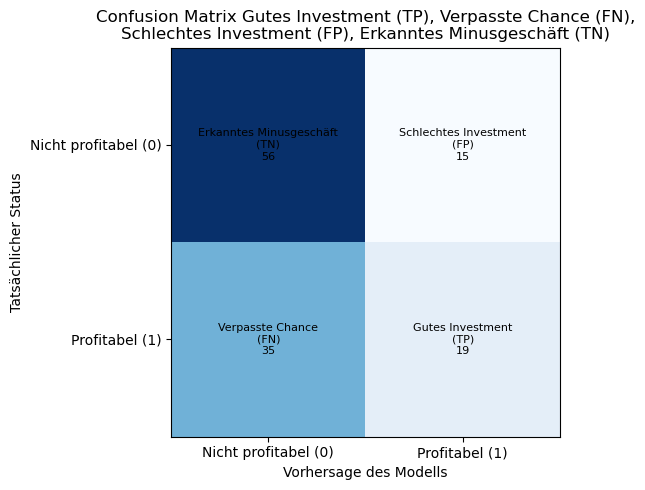

In [12]:
# --- ROC-AUC ---
roc_train = roc_auc_score(y_train, y_train_proba)
roc_test  = roc_auc_score(y_test,  y_test_proba)

print(f"ROC-AUC Train: {roc_train:.3f}")
print(f"ROC-AUC Test : {roc_test:.3f}\n")


# --- Klassifikationsmetriken ---
acc  = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec  = recall_score(y_test, y_test_pred)

print("Test-Metriken:")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")


# --- Confusion-Matrix mit Business-Begriffen ---
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")


ax.set_xlabel("Vorhersage des Modells")
ax.set_ylabel("Tatsächlicher Status")


ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Nicht profitabel (0)", "Profitabel (1)"])
ax.set_yticklabels(["Nicht profitabel (0)", "Profitabel (1)"])

ax.set_title(
    "Confusion Matrix Gutes Investment (TP), "

    "Verpasste Chance (FN),\n"

    "Schlechtes Investment (FP), Erkanntes Minusgeschäft (TN)"
)

business_labels = [
    ["Erkanntes Minusgeschäft\n(TN)", "Schlechtes Investment\n(FP)"],
    ["Verpasste Chance\n(FN)", "Gutes Investment\n(TP)"]
]

for i in range(2):
    for j in range(2):
        text = f"{business_labels[i][j]}\n{cm[i, j]}"
        ax.text(
            j, i,
            text,
            ha="center",
            va="center",
            color="black",
            fontsize=8
        )

fig.tight_layout()
plt.show()

##  Diskussion von Overfitting und Underfitting

Dieses Modell lässt sich abhängig von den Hyperparametern wiefolgt einordnen:

- Ein **zu komplexer Baum** (sehr große `max_depth`, kleine `min_samples_leaf`) würde
  - die Trainingsdaten fast perfekt trennen (sehr hohe ROC-AUC/Accuracy im Training),
  - aber auf den Testdaten deutlich schlechter abschneiden → **Overfitting (hohe Varianz)**.

- Ein **zu einfacher Baum** (sehr kleine `max_depth`, große `min_samples_leaf`) würde
  - sowohl auf Trainings- als auch Testdaten eher schlechte Werte liefern,
  - weil die Modellkapazität nicht ausreicht, die Zusammenhänge abzubilden → **Underfitting (hoher Bias)**.

In diesem Modell haben wir versucht einen **Kompromiss** zu finden:

- `max_depth = 7` begrenzt die Komplexität des Baums.
- `min_samples_leaf = 40` sorgt dafür, dass Blätter nicht nur auf sehr wenigen Startups basieren.

betrachteten wir unsere Metriken für unsere gewählten Hyperparamater kommen wir zum Schluss:

ROC-AUC Train: 0.687  trennt im Training okay, aber nicht stark. Erkennt Muster aber nicht Trennungsscharf.

ROC-AUC Test : 0.579  trennt im Test kaum besser als Zufall. 

-> Differenz ROC-AUC Training/Test = 0,108  Mittelgroßer Unterschied zwischen Test und Trainingserfolg.

Accuracy : 0.600     60% Aller Startups korrekt Klassifiziert, okay aber nicht Gut wenn man die Risiken abwägt.

Precision: 0.559   Nur 55,9% der als profitablen hervorgesagten Startups waren korrekt. Viele False Positives und somit für Investoren  sehr gefährlich.

Recall   : 0.352     Das Modell erkennt gerade mal 35,2% der tatsächlich profitablen Startups im Test.

**Fazit**

Das Modell overfittet ein wenig, weil die Differenz zwischen Test und Training mittelgroß ist.
Gleichzeitig underfittet es, weil beide Werte insgesamt schlecht sind.

**Gründe**

-Der Datensatz enthält gerademal 500 Startups. Die einzelnen Kombinationen von Region, Industrie, etc. sind so gering dass das Modell nicht genug Muster finden kann.

-Gleichzeitig sind die Umstände der Startups, wie Trends (zB. AI), Wirtschaftsschwankungen oder einfach Startupeinzigartige Qualitäten im Datensatz ebenfalls nicht erfasst.

-Das Modell ist mit diesem Datensatz nicht praxistauglich

## 4. Feature Importance des Decision Trees

Um das Modell besser erklären zu können (Explainable AI), wird die **Feature Importance** des Decision Trees ausgewertet.

- Sie zeigt, welche Features besonders stark zur Trennung der Klassen beitragen.
- So lassen sich fachliche Fragen beantworten wie:
  - Welche Rolle spielt der **Marktanteil**?
  - Wie wichtig sind **Finanzierungsrunden** oder **Kapital-Effizienz**?
  - Welche Branchen oder Regionen sind im Modell besonders relevant?

So kann Vertrauen zu den Investoren aufgebaut werden weil sie nicht auf eine Blackbox vertrauen müssen.
Gleichzeitig ermöglicht es ihnen festzustellen ob sie anders ihre Entscheidungen treffen als das Modell.

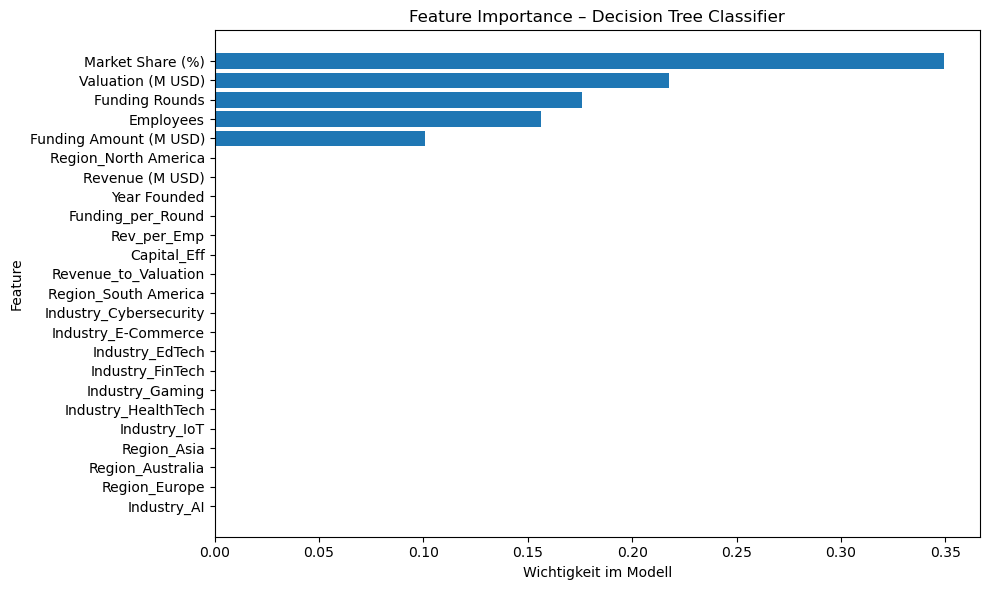

,Feature,Importance
5,Market Share (%),0.349184
2,Valuation (M USD),0.217628
0,Funding Rounds,0.176014
4,Employees,0.156354
1,Funding Amount (M USD),0.100821
21,Region_Europe,0.000000
22,Region_North America,0.000000
3,Revenue (M USD),0.000000
6,Year Founded,0.000000
7,Funding_per_Round,0.000000


In [14]:
# Zugriff auf das trainierte Baum-Modell und den One-Hot-Encoder
best_tree = pipe.named_steps["model"]
ohe = pipe.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]

# Feature-Namen: numerische Features + One-Hot-Features
feature_names = num + list(ohe.get_feature_names_out(cat))
importances = best_tree.feature_importances_

imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=True)

plt.figure(figsize=(10, max(6, len(imp_df) * 0.25)))
plt.barh(imp_df["Feature"], imp_df["Importance"])
plt.xlabel("Wichtigkeit im Modell")
plt.ylabel("Feature")
plt.title("Feature Importance – Decision Tree Classifier")
plt.tight_layout()
plt.show()

imp_df.sort_values("Importance", ascending=False).head(10)